# Captum Insights for Visual Question Answering

This notebook provides a simple example for the [Captum Insights API](https://captum.ai/docs/captum_insights), which is an easy to use API built on top of Captum that provides a visualization widget.

It is suggested to first read the multi-modal [tutorial](https://captum.ai/tutorials/Multimodal_VQA_Interpret) with VQA that utilises the `captum.attr` API. This tutorial will skip over a large chunk of details for setting up the VQA model.

As with the referenced tutorial, you will need the following installed on your machine:

- Python Packages: torchvision, PIL, and matplotlib
- pytorch-vqa: https://github.com/Cyanogenoid/pytorch-vqa
- pytorch-resnet: https://github.com/Cyanogenoid/pytorch-resnet
- A pretrained pytorch-vqa model, which can be obtained from: https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

Please modify the below section for your specific installation paths:

In [1]:
import sys, os

# Replace the placeholder strings with the associated 
# path for the root of pytorch-vqa and pytorch-resnet respectively
PYTORCH_VQA_DIR = os.path.realpath("../../pytorch-vqa")
PYTORCH_RESNET_DIR = os.path.realpath("../../pytorch-resnet")

# Please modify this path to where it is located on your machine
# you can download this model from: 
# https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth
VQA_MODEL_PATH = "models/2017-08-04_00.55.19.pth"

assert(os.path.exists(PYTORCH_VQA_DIR))
assert(os.path.exists(PYTORCH_RESNET_DIR))
assert(os.path.exists(VQA_MODEL_PATH))

sys.path.append(PYTORCH_VQA_DIR)
sys.path.append(PYTORCH_RESNET_DIR)

Now, we will import the necessary modules to run the code in this tutorial. Please make sure you have the [prerequisites to run captum](https://captum.ai/docs/getting_started), along with the pre-requisites to run this tutorial (as described in the first section).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

try:
    import resnet  # from pytorch-resnet
except:
    print("please provide a valid path to pytorch-resnet")

try:
    from model import Net, apply_attention, tile_2d_over_nd  # from pytorch-vqa
    from utils import get_transform  # from pytorch-vqa
except:
    print("please provide a valid path to pytorch-vqa")
    
from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature, TextFeature
from captum.attr import TokenReferenceBase, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [3]:
# Let's set the device we will use for model inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VQA Model Setup

Let's load the VQA model (again, please refer to the [model interpretation tutorial on VQA](https://captum.ai/tutorials/Multimodal_VQA_Interpret) if you want details)

In [ ]:
saved_state = torch.load(VQA_MODEL_PATH, map_location=device)

# reading vocabulary from saved model
vocab = saved_state["vocab"]

# reading word tokens from saved model
token_to_index = vocab["question"]

# reading answers from saved model
answer_to_index = vocab["answer"]

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ["unk"] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx] = w

vqa_net = torch.nn.DataParallel(Net(num_tokens), device_ids=[0, 1])
vqa_net.load_state_dict(saved_state["weights"])
vqa_net = vqa_net.to(device)

In [5]:
 # for visualization to convert indices to tokens for questions
question_words = ["unk"] * num_tokens
for w, idx in token_to_index.items():
    question_words[idx] = w

Let's modify the VQA model to use pytorch-resnet. Our model will be called `vqa_resnet`.

In [6]:
class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True)
        self.r_model.eval()
        self.r_model.to(device)
        self.buffer = None

        def save_output(module, input, output):
            self.buffer = output

        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.r_model(x)
        return self.buffer

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()

    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = self.resnet_layer4(v)

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer

vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)

# `device_ids` contains a list of GPU ids which are used for parallelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet, device_ids=[0, 1])

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.state_dict()
state.update(partial_dict)
vqa_resnet.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net

# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled = False

# Input Utilities

Now we will need some utility functions for the inputs of our model. 

Let's start off with our image input transform function. We will separate out the normalization step from the transform in order to view the original image.

In [7]:
image_size = 448  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
transform_normalize = transform.transforms.pop()

/opt/homebrew/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Now for the input question, we will need an encoding function (to go from words -> indices):

In [8]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

# Baseline Inputs 

The insights API utilises captum's attribution API under the hood, hence we will need a baseline for our inputs. A baseline is (typically) a neutral output to reference in order for our attribution algorithm(s) to understand which features are important in making a prediction (this is very simplified explanation, 'Remark 1' in the [Integrated Gradients paper](https://arxiv.org/pdf/1703.01365.pdf) has an excellent explanation on why they must be utilised).

For images and for the purpose of this tutorial, we will let this baseline be the zero vector (a black image).

In [9]:
def baseline_image(x):
    return x * 0

For sentences, as done in the multi-modal VQA tutorial, we will use a sentence composed of padded symbols.

We will also require to pass our model through the [`configure_interpretable_embedding_layer`](https://captum.ai/api/utilities.html?highlight=configure_interpretable_embedding_layer#captum.attr._models.base.configure_interpretable_embedding_layer) function, which separates the embedding layer and precomputes word embeddings. To put it simply, this function allows us to precompute and give the embedding vectors directly to our model, which will allow us to reference the words associated to particular embeddings (for visualization purposes).

In [10]:
interpretable_embedding = configure_interpretable_embedding_layer(
    vqa_resnet, "module.text.embedding"
)

PAD_IND = token_to_index["pad"]
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

def baseline_text(x):
    seq_len = x.size(0)
    ref_indices = token_reference.generate_reference(seq_len, device=device).unsqueeze(
        0
    )
    return interpretable_embedding.indices_to_embeddings(ref_indices).squeeze(0)

def input_text_transform(x):
    return interpretable_embedding.indices_to_embeddings(x)

../captum/attr/_models/base.py:168: UserWarning: In order to make embedding layers more interpretable they will
        be replaced with an interpretable embedding layer which wraps the
        original embedding layer and takes word embedding vectors as inputs of
        the forward function. This allows to generate baselines for word
        embeddings and compute attributions for each embedding dimension.
        The original embedding layer must be set
        back by calling `remove_interpretable_embedding_layer` function
        after model interpretation is finished.
  after model interpretation is finished."""


# Using the Insights API

Finally we have reached the relevant part of the tutorial.

First let's create a utility function to allow us to pass data into the insights API. This function will essentially produce `Batch` objects, which tell the insights API what your inputs, labels and any additional arguments are.

In [11]:
def vqa_dataset(image, questions, targets):
    img = Image.open(image).convert("RGB")
    img = transform(img).unsqueeze(0)

    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)

        q = q.unsqueeze(0)
        q_len = q_len.unsqueeze(0)

        target_idx = answer_to_index[target]

        yield Batch(
            inputs=(img, q), labels=(target_idx,), additional_args=q_len
        )

Let's create our `AttributionVisualizer`, to do this we need the following:

- A score function, which tells us how to interpret the model's output vector
- Description of the input features given to the model
- The data to visualize (as described above)
- Description of the output (the class names), in our case this is our answer words

In our case, we want to produce a single answer output via softmax

In [12]:
def score_func(o):
    return F.softmax(o, dim=1)

The following function will convert a sequence of question indices to the associated question words for visualization purposes. This will be provided to the `TextFeature` object to describe text features.

In [13]:
def itos(input):
    return [question_words[int(i)] for i in input.squeeze(0)]

Let's define some dummy data to visualize using the function we declared earlier.

In [14]:
dataset = vqa_dataset("./img/vqa/elephant.jpg", 
    ["what is on the picture",
    "what color is the elephant",
    "where is the elephant" ],
    ["elephant", "gray", "zoo"]
)

Now let's describe our features. Each feature requires an input transformation function and a set of baselines. As described earlier, we will use the black image for the image baseline and a padded sequence for the text baseline.

The input image will be transformed via our normalization transform (`transform_normalize`).
Our input text will need to be transformed into embeddings, as it is a sequence of indices. Our model only accepts embeddings as input, as we modified the model with `configure_interpretable_embedding_layer` earlier.

We also need to provide how the input text should be transformed in order to be visualized, which will be accomplished through the `itos` function, as described earlier.

In [15]:
features = [
    ImageFeature(
        "Picture",
        input_transforms=[transform_normalize],
        baseline_transforms=[baseline_image],
    ),
    TextFeature(
        "Question",
        input_transforms=[input_text_transform],
        baseline_transforms=[baseline_text],
        visualization_transform=itos,
    ),
]

Let's define our AttributionVisualizer object with the above parameters and our `vqa_resnet` model. 

In [16]:
visualizer = AttributionVisualizer(
    models=[vqa_resnet],
    score_func=score_func,
    features=features,
    dataset=dataset,
    classes=answer_words,
)

And now we can visualize the outputs produced by the model.

As of writing this tutorial, the `AttributionVisualizer` class utilizes captum's implementation of [integrated gradients](https://captum.ai/docs/algorithms#integrated-gradients) ([`IntegratedGradients`](https://captum.ai/api/integrated_gradients.html)).

In [ ]:
visualizer.render()

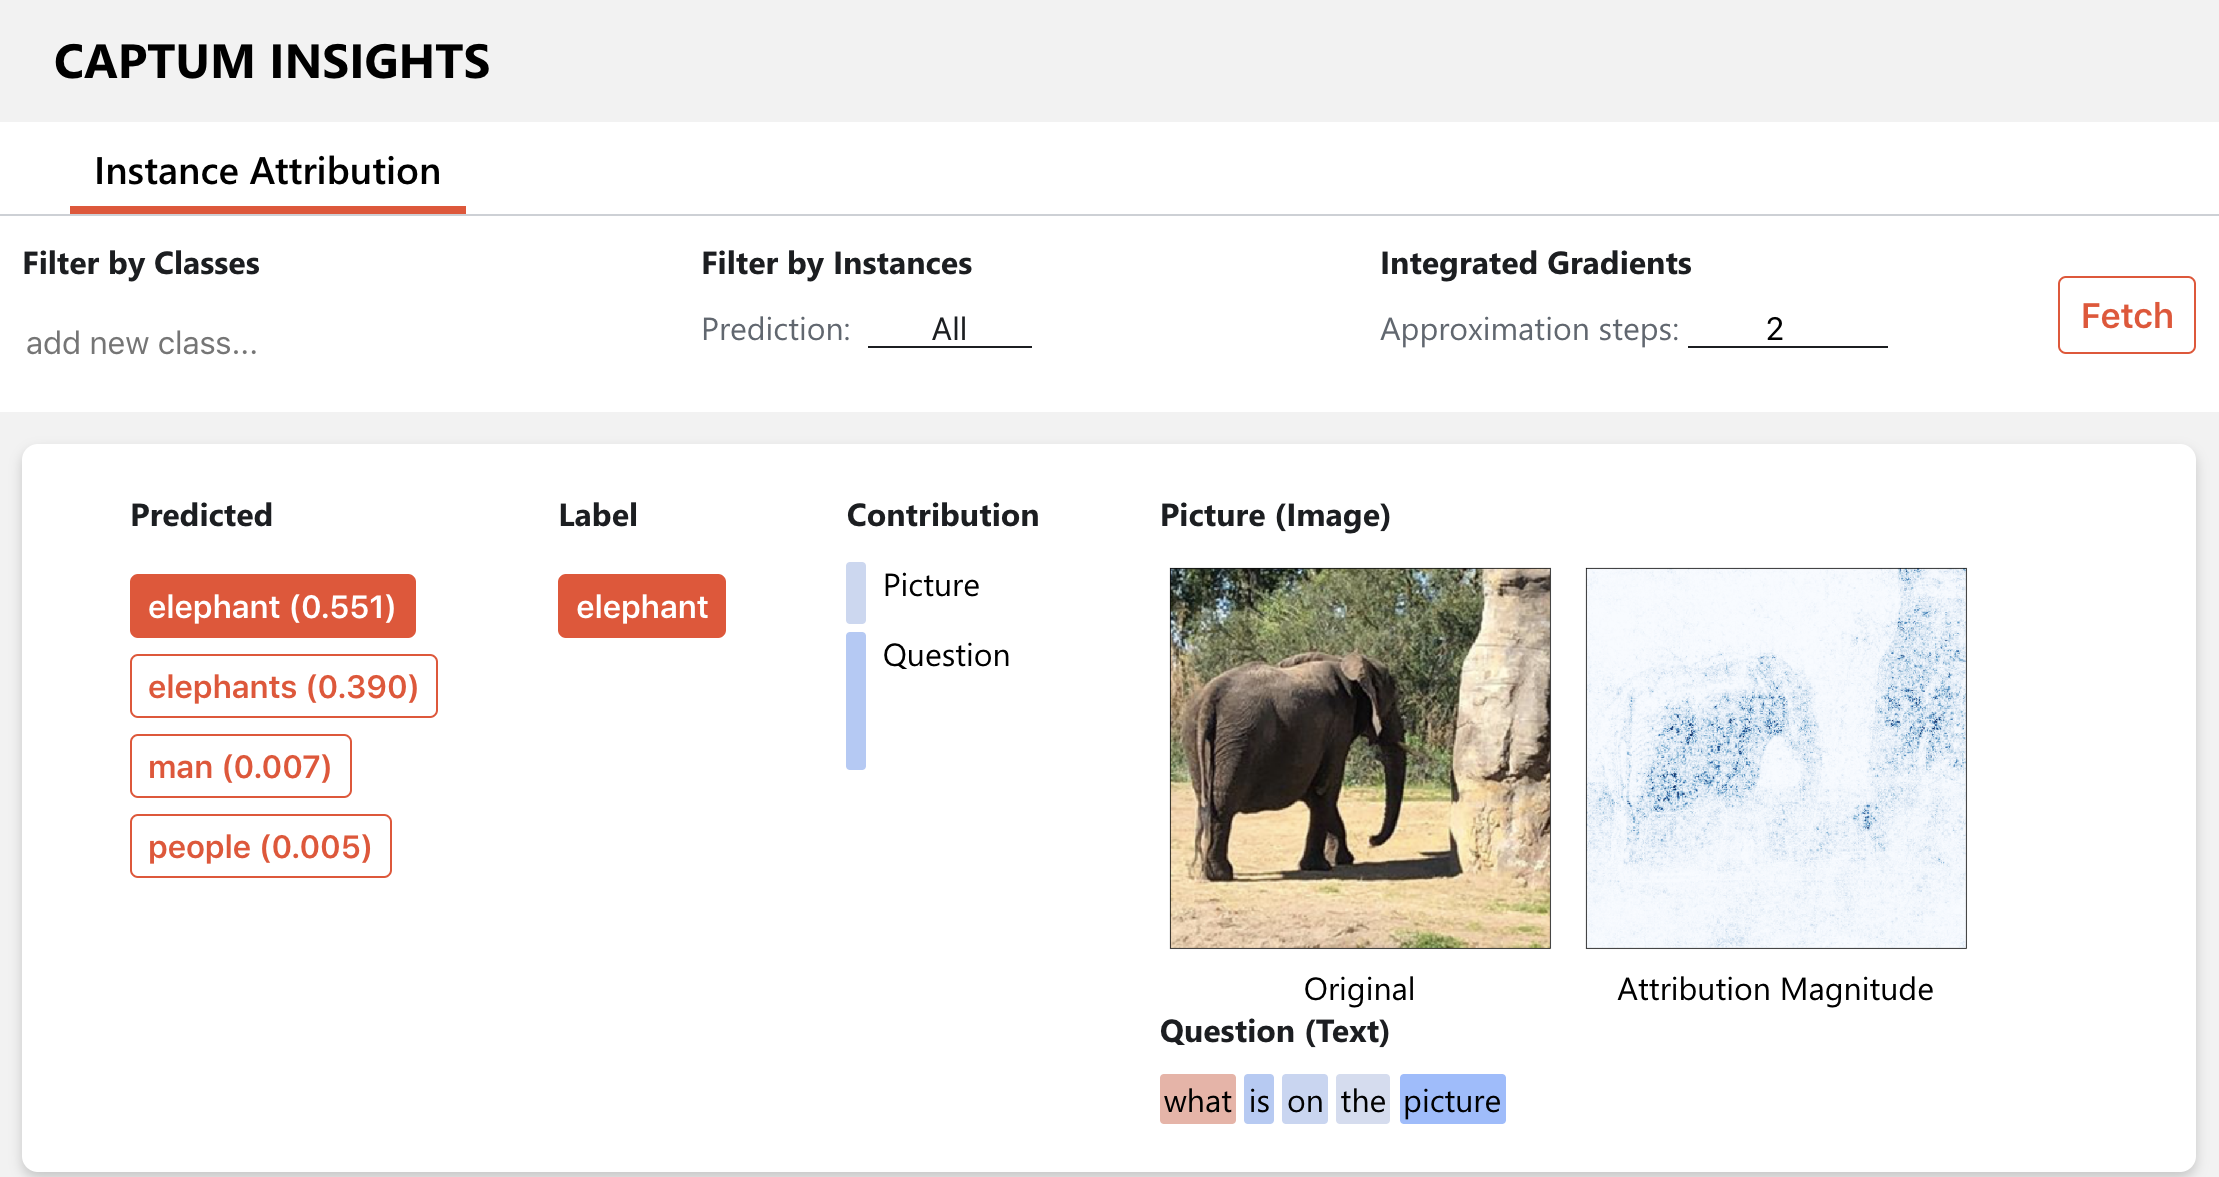

In [18]:
# show a screenshot if using notebook non-interactively
from IPython.display import Image
Image(filename='img/captum_insights_vqa.png')

Finally, since we are done with visualization, we will revert the change to the model we made with `configure_interpretable_embedding_layer`. To do this, we will invoke the `remove_interpretable_embedding_layer` function.

In [19]:
remove_interpretable_embedding_layer(vqa_resnet, interpretable_embedding)